**In this chapter, we will be using the Iris dataset**

# 1) Visualization is a good first step

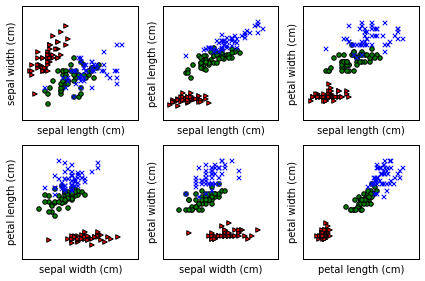

In [67]:
# %load figure1.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

from matplotlib import pyplot as plt

# We load the data with load_iris from sklearn
from sklearn.datasets import load_iris

# load_iris returns an object with several fields
data = load_iris()
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

fig,axes = plt.subplots(2, 3)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
        ('r', '>'),
        ('g', 'o'),
        ('b', 'x'),
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[
                    target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('figure1.png')


In [46]:
# %load chapter.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# We load the data with load_iris from sklearn
from sklearn.datasets import load_iris
data = load_iris()

# load_iris returns an object with several fields
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

features[0:2]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2]])

In [47]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [48]:
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [49]:
target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='|S10')

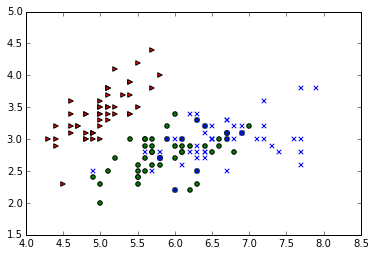

In [50]:
for t in range(3):
 if t == 0:
     c = 'r'
     marker = '>'
 elif t == 1:
     c = 'g'
     marker = 'o'
 elif t == 2:
     c = 'b'
     marker = 'x'
 plt.scatter(features[target == t, 0],
            features[target == t, 1],
            marker=marker,
            c=c)

# 2) Building our first classification model

If the goal is to separate the three types of flowers, we can immediately make a few
suggestions just by looking at the data. For example, petal length seems to be able
to separate Iris Setosa from the other two flower species on its own.

In [51]:
# We use NumPy fancy indexing to get an array of strings:
labels = target_names[target]
labels[0:10]

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa'], 
      dtype='|S10')

In [52]:
# The petal length is the feature at position 2
plength = features[:, 2]

# Build an array of booleans:
is_setosa = (labels == 'setosa')
is_setosa[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [53]:
# This is the important step:
max_setosa =plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()
print('Maximum of setosa: {0}.'.format(max_setosa))

print('Minimum of others: {0}.'.format(min_non_setosa))

Maximum of setosa: 1.9.
Minimum of others: 3.0.


Therefore, we can build a simple model: if the petal length is smaller than 2, then
this is an Iris Setosa flower; otherwise it is either Iris Virginica or Iris Versicolor.

The problem of recognizing Iris Setosa apart from the other two species was
very easy. However, we cannot immediately see what the best threshold is for
distinguishing Iris Virginica from Iris Versicolor. We can even see that we will never
achieve perfect separation with these features. We could, however, look for the best
possible separation, the separation that makes the fewest mistakes. For this, we will
perform a little computation.

In [54]:
# ~ is the boolean negation operator
features = features[~is_setosa]
labels = labels[~is_setosa]

In [55]:
np.unique(labels)

array(['versicolor', 'virginica'], 
      dtype='|S10')

In [56]:
# Build a new target variable, is_virigina
is_virginica = (labels == 'virginica')

The is_setosa array is a
Boolean array and we use it to select a subset of the other two arrays, features and
labels. Finally, we build a new boolean array, virginica, by using an equality
comparison on labels.

Now, we run a loop over all possible features and thresholds to see which one
results in better accuracy. Accuracy is simply the fraction of examples that the
model classifies correctly.

In [57]:
# Initialize best_acc to impossibly low value
best_acc = -1.0
for fi in range(features.shape[1]):
    # We are going to test all possible thresholds
    thresh = features[:,fi]
    for t in thresh:

        # Get the vector for feature `fi`
        feature_i = features[:, fi]
        # apply threshold `t`
        pred = (feature_i > t)
        acc = (pred == is_virginica).mean()
        rev_acc = (pred == ~is_virginica).mean()
        if rev_acc > acc:
            reverse = True
            acc = rev_acc
        else:
            reverse = False

        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t
            best_reverse = reverse

print(best_fi, best_t, best_reverse, best_acc)

(3, 1.6000000000000001, False, 0.93999999999999995)


In [58]:
def is_virginica_test(fi, t, reverse, example):
    'Apply threshold model to a new example'
    test = example[fi] > t
    if reverse:
        test = not test
    return test

What does this model look like? If we run the code on the whole data, the model that
is identified as the best makes decisions by splitting on the petal width. One way
to gain intuition about how this works is to visualize the decision boundary. That
is, we can see which feature values will result in one decision versus the other and
exactly where the boundary is.

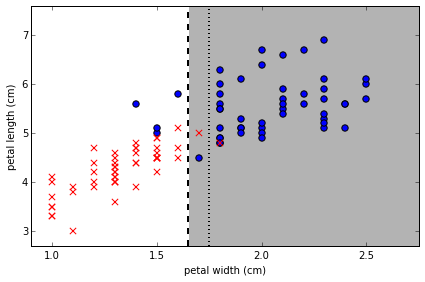

In [69]:
# %load figure2.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

COLOUR_FIGURE = False

from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
data = load_iris()
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

# We use NumPy fancy indexing to get an array of strings:
labels = target_names[target]

is_setosa = (labels == 'setosa')
features = features[~is_setosa]
labels = labels[~is_setosa]
is_virginica = (labels == 'virginica')

# Hand fixed thresholds:
t = 1.65
t2 = 1.75

# Features to use: 3 & 2
f0, f1 = 3, 2

if COLOUR_FIGURE:
    area1c = (1., .8, .8)
    area2c = (.8, .8, 1.)
else:
    area1c = (1., 1, 1)
    area2c = (.7, .7, .7)

# Plot from 90% of smallest value to 110% of largest value
# (all feature values are positive, otherwise this would not work very well)

x0 = features[:, f0].min() * .9
x1 = features[:, f0].max() * 1.1

y0 = features[:, f1].min() * .9
y1 = features[:, f1].max() * 1.1

fig,ax = plt.subplots()
ax.fill_between([t, x1], [y0, y0], [y1, y1], color=area2c)
ax.fill_between([x0, t], [y0, y0], [y1, y1], color=area1c)
ax.plot([t, t], [y0, y1], 'k--', lw=2)
ax.plot([t2, t2], [y0, y1], 'k:', lw=2)
ax.scatter(features[is_virginica, f0],
            features[is_virginica, f1], c='b', marker='o', s=40)
ax.scatter(features[~is_virginica, f0],
            features[~is_virginica, f1], c='r', marker='x', s=40)
ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)
ax.set_xlabel(feature_names[f0])
ax.set_ylabel(feature_names[f1])
fig.tight_layout()
fig.savefig('figure2.png')


# 3) Evaluation – holding out data and cross-validation

In [71]:
# %load heldout.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

# This script demonstrates the difference between the training accuracy and
# testing (held-out) accuracy.

import numpy as np
from sklearn.datasets import load_iris
from threshold import fit_model, accuracy

data = load_iris()
features = data['data']
labels = data['target_names'][data['target']]

# We are going to remove the setosa examples as they are too easy:
is_setosa = (labels == 'setosa')
features = features[~is_setosa]
labels = labels[~is_setosa]

# Now we classify virginica vs non-virginica
is_virginica = (labels == 'virginica')

# Split the data in two: testing and training
testing = np.tile([True, False], 50) # testing = [True,False,True,False,True,False...]

# Training is the negation of testing: i.e., datapoints not used for testing,
# will be used for training
training = ~testing

model = fit_model(features[training], is_virginica[training])
train_accuracy = accuracy(features[training], is_virginica[training], model)
test_accuracy = accuracy(features[testing], is_virginica[testing], model)

print('''\
Training accuracy was {0:.1%}.
Testing accuracy was {1:.1%} (N = {2}).
'''.format(train_accuracy, test_accuracy, testing.sum()))


Training accuracy was 96.0%.
Testing accuracy was 90.0% (N = 50).



In [59]:
from threshold import fit_model, predict

# ning accuracy was 96.0%.
# ing accuracy was 90.0% (N = 50).
correct = 0.0

for ei in range(len(features)):
    # select all but the one at position `ei`:
    training = np.ones(len(features), bool)
    training[ei] = False
    testing = ~training
    model = fit_model(features[training], is_virginica[training])
    predict(model, features[testing])
    predictions = predict(model, features[testing])
    correct += np.sum(predictions == is_virginica[testing])
acc = correct/float(len(features))
print('Accuracy: {0:.1%}'.format(acc))

Accuracy: 87.0%


# 4) More complex model

In [76]:
###########################################
############## SEEDS DATASET ##############
###########################################

from load import load_dataset

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
features, labels = load_dataset('seeds')
print features[0]
print np.unique(labels)

[ 15.26   14.84    0.871   5.763   3.312   2.221   5.22 ]
['Canadian' 'Kama' 'Rosa']


# 5) Classifying with scikit-learn

In [77]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
from sklearn.cross_validation import KFold

kf = KFold(len(features), n_folds=5, shuffle=True)
# `means` will be a list of mean accuracies (one entry per fold)
means = []
for training,testing in kf:
   # We learn a model for this fold with `fit` and then apply it to the
   # testing data with `predict`:
   classifier.fit(features[training], labels[training])
   prediction = classifier.predict(features[testing])

   # np.mean on an array of booleans returns fraction
 # of correct decisions for this fold:
   curmean = np.mean(prediction == labels[testing])
   means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 89.0%


# 6) Looking at the decision boundaries

In [78]:
# %load figure4_5_no_sklearn.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

COLOUR_FIGURE = False

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from load import load_dataset
import numpy as np
from knn import fit_model, predict

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]


def plot_decision(features, labels):
    '''Plots decision boundary for KNN

    Parameters
    ----------
    features : ndarray
    labels : sequence

    Returns
    -------
    fig : Matplotlib Figure
    ax  : Matplotlib Axes
    '''
    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 100)
    Y = np.linspace(y0, y1, 100)
    X, Y = np.meshgrid(X, Y)

    model = fit_model(1, features[:, (0, 2)], np.array(labels))
    C = predict(
        np.vstack([X.ravel(), Y.ravel()]).T, model).reshape(X.shape)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .6, .6), (.6, 1., .6), (.6, .6, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])
    fig,ax = plt.subplots()
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .0, .0), (.0, 1., .0), (.0, .0, 1.)])
        ax.scatter(features[:, 0], features[:, 2], c=labels, cmap=cmap)
    else:
        for lab, ma in zip(range(3), "Do^"):
            ax.plot(features[labels == lab, 0], features[
                     labels == lab, 2], ma, c=(1., 1., 1.))
    return fig,ax


features, labels = load_dataset('seeds')
names = sorted(set(labels))
labels = np.array([names.index(ell) for ell in labels])

fig,ax = plot_decision(features, labels)
fig.savefig('figure4.png')

features -= features.mean(0)
features /= features.std(0)
fig,ax = plot_decision(features, labels)
fig.savefig('figure5.png')


ValueError: too many values to unpack

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

means = []
for training,testing in kf:
    # We learn a model for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])

    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 91.0%


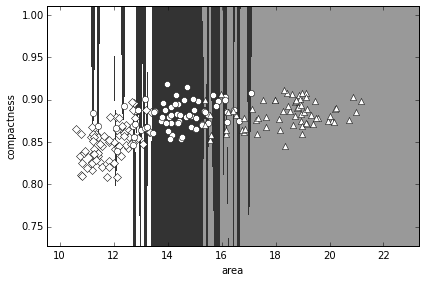

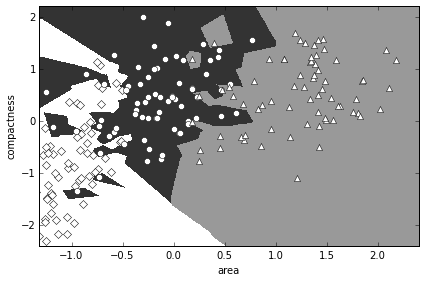

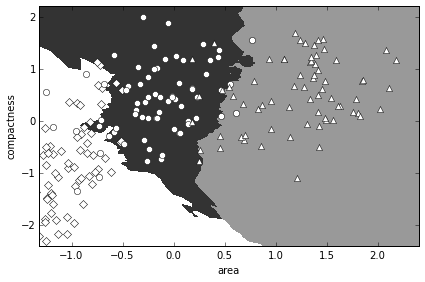

In [82]:
# %load figure4_5_sklearn.py
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

COLOUR_FIGURE = False

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from load import load_dataset
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]


def plot_decision(features, labels, num_neighbors=1):
    '''Plots decision boundary for KNN

    Parameters
    ----------
    features : ndarray
    labels : sequence

    Returns
    -------
    fig : Matplotlib Figure
    ax  : Matplotlib Axes
    '''
    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)

    model = KNeighborsClassifier(num_neighbors)
    model.fit(features[:, (0,2)], labels)
    C = model.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])
    fig,ax = plt.subplots()
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .0, .0), (.1, .6, .1), (.0, .0, 1.)])
        ax.scatter(features[:, 0], features[:, 2], c=labels, cmap=cmap)
    else:
        for lab, ma in zip(range(3), "Do^"):
            ax.plot(features[labels == lab, 0], features[
                     labels == lab, 2], ma, c=(1., 1., 1.), ms=6)
    return fig,ax


features, labels = load_dataset('seeds')
names = sorted(set(labels))
labels = np.array([names.index(ell) for ell in labels])

fig,ax = plot_decision(features, labels)
fig.tight_layout()
fig.savefig('figure4sklearn.png')

features -= features.mean(0)
features /= features.std(0)
fig,ax = plot_decision(features, labels)
fig.tight_layout()
fig.savefig('figure5sklearn.png')

fig,ax = plot_decision(features, labels, 11)
fig.tight_layout()
fig.savefig('figure5sklearn_with_11_neighbors.png')
